In [1]:
# import package
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.feature_importance import mean_score_decrease

In [2]:
# import data
df = pd.read_csv('life_expectancy.csv')
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,BMI,u5_deaths,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
df.isna().sum()

country                     0
year                        0
status                      0
life_expectancy            10
adult_mortality            10
infant_deaths               0
alcohol                   194
percentage_expenditure      0
HepB                      553
measles                     0
BMI                        34
u5_deaths                   0
Polio                      19
total_expenditure         226
DPT                        19
HIV_AIDS                    0
GDP                       448
population                652
thinness_10_19             34
thinness_5_9               34
HDI                       167
school_year               163
dtype: int64

In [5]:
df = df[~df.life_expectancy.isna()]
df.isna().sum()

country                     0
year                        0
status                      0
life_expectancy             0
adult_mortality             0
infant_deaths               0
alcohol                   193
percentage_expenditure      0
HepB                      553
measles                     0
BMI                        32
u5_deaths                   0
Polio                      19
total_expenditure         226
DPT                        19
HIV_AIDS                    0
GDP                       443
population                644
thinness_10_19             32
thinness_5_9               32
HDI                       160
school_year               160
dtype: int64

In [6]:
X = df.drop(columns=['life_expectancy'])
y = df.life_expectancy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2342, 21), (586, 21), (2342,), (586,))

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [9]:
X.columns

Index(['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'],
      dtype='object')

In [10]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [11]:
# training
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['year', 'adult_mortality', 'infant_deaths',
                            'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
                            'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
                            'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']),
    ('categoric', cat_pipe(encoder='onehot'), ['country', 'status'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=--1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.42066805426927745, 'algo__gamma': 1, 'algo__learning_rate': 0.035015835937029005, 'algo__max_depth': 9, 'algo__n_estimators': 176, 'algo__reg_alpha': 2.772824182801065, 'algo__reg_lambda': 0.0010661259689433889, 'algo__subsample': 0.5553736512887829}
0.9865252262096966 0.957951869451762 0.9650497274770851


## feature importance

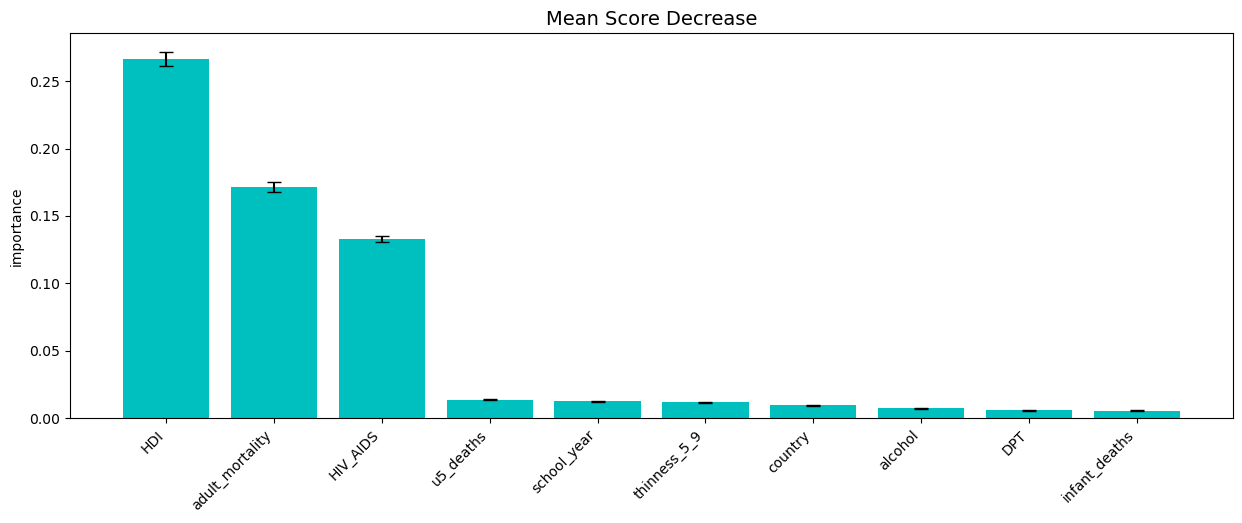

In [12]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [13]:
# mengambil 5 feature paling berpengaruh
list(df_imp.feature)[:5]

['HDI', 'adult_mortality', 'HIV_AIDS', 'u5_deaths', 'school_year']

In [14]:
# training
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['HDI', 'adult_mortality', 'HIV_AIDS', 'u5_deaths', 'school_year'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=--1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.9174392973699884, 'algo__gamma': 3, 'algo__learning_rate': 0.22983221528155043, 'algo__max_depth': 5, 'algo__n_estimators': 143, 'algo__reg_alpha': 0.061820520641258085, 'algo__reg_lambda': 0.16276924772060908, 'algo__subsample': 0.5963483619396968}
0.9901380284181381 0.9471120357537016 0.9523772735854334


In [15]:
list(df_imp.feature)[:10]

['HDI',
 'adult_mortality',
 'HIV_AIDS',
 'u5_deaths',
 'school_year',
 'thinness_5_9',
 'country',
 'alcohol',
 'DPT',
 'infant_deaths']

In [16]:
# training
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['HDI','adult_mortality','HIV_AIDS','u5_deaths',
                            'school_year','thinness_5_9','total_expenditure',
                            'alcohol','DPT','infant_deaths'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=--1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6914001956501502, 'algo__gamma': 5, 'algo__learning_rate': 0.16727902653067211, 'algo__max_depth': 7, 'algo__n_estimators': 166, 'algo__reg_alpha': 0.009793184984206244, 'algo__reg_lambda': 0.02653937643936054, 'algo__subsample': 0.6789230552321847, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.9949247882477756 0.9562921676314735 0.9658276033824575


## BayesSearchCV

In [17]:
from skopt import BayesSearchCV
from jcopml.tuning import bayes_search_params as bsp

In [18]:
# training
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['year', 'adult_mortality', 'infant_deaths',
                            'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
                            'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
                            'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']),
    ('categoric', cat_pipe(encoder='onehot'), ['country', 'status'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=--1, random_state=42))
])

model = BayesSearchCV(pipeline, bsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [19]:
save_model(model.best_estimator_, 'xgb.pkl')

Model is pickled as model/xgb.pkl
